This notebook is an adaptation of ForneyLab.jl demo at https://github.com/biaslab/ForneyLab.jl/blob/master/demo/hidden_markov_model_estimation.ipynb

In [1]:
using Revise
using DrWatson

In [2]:
@quickactivate :ReactiveMPPaperExperiments

┌ Info: Precompiling ReactiveMPPaperExperiments [adcd1038-27e6-4580-819b-caa5dba07e45]
└ @ Base loading.jl:1342


In [3]:
using ForneyLab
using BenchmarkTools
using Random
using CairoMakie

In [4]:
import Distributions

In [129]:
params = let
    # Seed for reproducability
    seed = 42
    
    # Number of samples in dataset
    n = 250
    
    # Transition probabilities (some transitions are impossible)
    A = [0.9 0.0 0.1; 0.1 0.9 0.0; 0.0 0.1 0.9]
    
    # Observation noise
    B = [0.05 0.05 0.9; 0.05 0.9 0.05; 0.9 0.05 0.05] 
    
    @strdict seed n A B
end;

In [130]:
z_data, y_data = generate_data(HMMModel(), params);

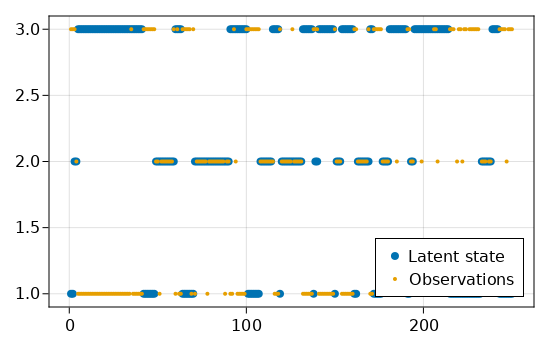

In [131]:
let 
    fig = Figure(resolution = (550, 350))
    ax  = Axis(fig[1, 1])
    
    range = 1:length(z_data)
    
    scatter!(ax, range, argmax.(z_data), markersize = 8, label = "Latent state")
    scatter!(ax, range, argmax.(y_data), markersize = 4, label = "Observations")
    
    axislegend(ax, position = :rb)
    
    fig
end

In [132]:
g = FactorGraph()

model_n = params["n"]

@RV A ~ Dirichlet(ones(3,3)) # Vague prior on transition model
@RV B ~ Dirichlet([ 1.0 1.0 10.0; 1.0 10.0 1.0; 10.0 1.0 1.0 ]) # Stronger prior on observation model

z = Vector{Variable}(undef, model_n) # one-hot coding
y = Vector{Variable}(undef, model_n) # one-hot coding

@RV z[1] ~ Categorical(fill(1.0 / 3.0, 3))
@RV y[1] ~ Transition(z[1], B)
placeholder(y[1], :y, index=1, dims=(3,))

for t = 2:model_n
    @RV z[t] ~ Transition(z[t - 1], A)
    @RV y[t] ~ Transition(z[t], B)
    placeholder(y[t], :y, index=t, dims=(3,))
end;

In [133]:
@time begin
    # Generate VMP algorithm with free energy
    pfz = PosteriorFactorization(A, B, z, ids=[:A, :B, :Z])
    algo = messagePassingAlgorithm(free_energy=true) # Generate algorithm
    source_code = algorithmSourceCode(algo, free_energy=true); # Generate source code for algorithm
    eval(Meta.parse(source_code)); # Load algorithm
end

 97.687457 seconds (11.23 M allocations: 6.425 GiB, 1.33% gc time)


freeEnergy (generic function with 1 method)

In [134]:
@time begin
    # Generate VMP algorithm with free energy
    pfz = PosteriorFactorization(A, B, z, ids=[:A, :B, :Z])
    algo = messagePassingAlgorithm(free_energy=true) # Generate algorithm
    source_code = algorithmSourceCode(algo, free_energy=true); # Generate source code for algorithm
    eval(Meta.parse(source_code)); # Load algorithm
end

 97.056316 seconds (11.23 M allocations: 6.425 GiB, 1.31% gc time)


freeEnergy (generic function with 1 method)

In [135]:
@time begin
    # Generate VMP algorithm with free energy
    pfz = PosteriorFactorization(A, B, z, ids=[:A, :B, :Z])
    algo = messagePassingAlgorithm(free_energy=true) # Generate algorithm
    source_code = algorithmSourceCode(algo, free_energy=true); # Generate source code for algorithm
    eval(Meta.parse(source_code)); # Load algorithm
end

 97.316620 seconds (11.23 M allocations: 6.425 GiB, 1.33% gc time)


freeEnergy (generic function with 1 method)

In [136]:
# Because of the global evaluation we cannot robustly perform this benchmark in a loop like we did for Turing and ReactiveMP
# So we change number of observations by hand and perform benchmarks separately 
# ForneyLab model creation time times
# 50  - 20.418973 seconds (2.19 M allocations: 1.250 GiB, 1.26% gc time)
# 100 - 39.180089 seconds (4.44 M allocations: 2.527 GiB, 1.23% gc time)
# 250 - 99.259535 seconds (11.23 M allocations: 6.425 GiB, 1.33% gc time)

In [137]:
data = Dict(:y => y_data) # Prepare data dictionary
;

In [138]:
function inference(data)
   # Initial posterior factors
    marginals = Dict{Symbol, ProbabilityDistribution}(
        :A => vague(Dirichlet, (3,3)),
        :B => vague(Dirichlet, (3,3)))

    # Initialize data
    n_its = 20

    # Run algorithm
    F = Vector{Float64}(undef, n_its)
    for i = 1:n_its
        stepZ!(data, marginals)
        stepA!(data, marginals)
        stepB!(data, marginals)
        
        F[i] = freeEnergy(data, marginals)
    end
    
    marginals, F
end

inference (generic function with 1 method)

In [139]:
@time inference(data);

306.690375 seconds (10.18 M allocations: 483.654 MiB, 0.03% gc time, 99.89% compilation time)


In [140]:
# ForneyLab compilation time
# 50  - 10.808682 seconds (2.18 M allocations: 109.735 MiB, 0.25% gc time, 99.46% compilation time)
# 100 - 43.100315 seconds (4.17 M allocations: 202.856 MiB, 0.08% gc time, 99.76% compilation time)
# 250 - 306.690375 seconds (10.18 M allocations: 483.654 MiB, 0.03% gc time, 99.89% compilation time)

In [141]:
@time inference(data);

  0.324510 seconds (1.54 M allocations: 107.342 MiB, 15.95% gc time)


In [142]:
@time inference(data);

  0.273665 seconds (1.54 M allocations: 107.342 MiB, 8.59% gc time)


In [143]:
@btime inference($data);

  228.291 ms (1535488 allocations: 107.34 MiB)


In [144]:
# ForneyLab execution times
# 50 - 46.888 ms (311485 allocations: 21.66 MiB)
# 100 - 93.172 ms (617488 allocations: 43.10 MiB)
# 250 - 228.291 ms (1535488 allocations: 107.34 MiB)

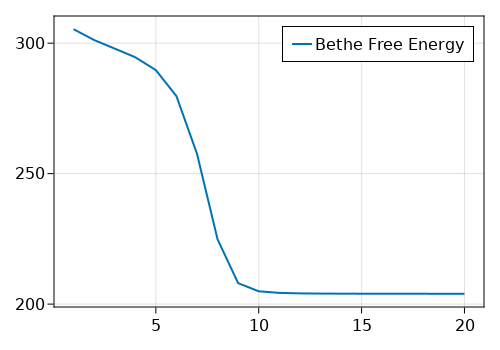

In [145]:
inferred, fe = inference(data);
z_estimated = map(i -> inferred[Symbol(:z_, i)], 1:model_n) 
;

let
    fig = Figure(resolution = (500, 350))
    ax  = Axis(fig[1, 1])

    lines!(ax, 1:length(fe), fe, label = "Bethe Free Energy", linewidth = 2)

    axislegend(ax, labelsize = 16, position = :rt)

    @saveplot fig "hmm_fe_fl"
end

In [146]:
println("Average MSE: $(average_mse(z_data, z_estimated))")

Average MSE: 24.901109861094866


In [147]:
# ForneyLab average MSE
# 50 - 1.5182392876607715
# 100 - 8.86958359640729
# 250 - 24.901109861094866

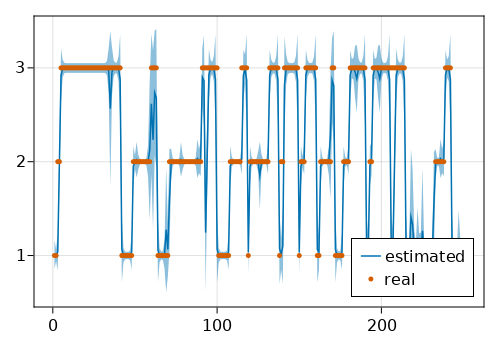

In [148]:
let
    fig = Figure(resolution = (500, 350))
    ax  = Axis(fig[1, 1])

    range       = 1:length(z_data)
    z_states    = argmax.(z_data)
    z_est       = Distributions.mean.(Distributions.Categorical.(ForneyLab.unsafeMeanVector.(z_estimated)))
    z_err       = Distributions.std.(Distributions.Categorical.(ForneyLab.unsafeMeanVector.(z_estimated)))
    c           = Makie.wong_colors()

    lines!(ax, range, z_est, color = c[1], label = "estimated")
    band!(ax, range, z_est .- z_err, z_est .+ z_err, color = (c[1], 0.45))
    scatter!(ax, range, z_states, color = c[6], markersize = 5, label = "real")
    
    axislegend(ax, labelsize = 16, position = :rb)

    @saveplot fig "hmm_inference_fl"
end